In [1]:
# Cell 1 - system

import sys
sys.path.append('src')

from __future__ import annotations
import torch

from typing import Callable

import torch
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torchdiffeq import odeint

import os
import re
from importlib.resources import files
from pathlib import Path

import numpy as np
import soundfile as sf
import tomli
from cached_path import cached_path

from f5_tts.infer.utils_infer import (
    infer_single_process,
    load_model,
    load_vocoder,
    preprocess_ref_audio_text,
    remove_silence_for_generated_wav,
)


from f5_tts.model.utils import (
    default,
    exists,
    lens_to_mask,
    list_str_to_idx,
    list_str_to_tensor,
    mask_from_frac_lengths,
)

from f5_tts.model import DiT, UNetT

# Direct variable assignments instead of command line arguments
model = "F5-TTS"
ckpt_file = "ckpts/russian_dataset_ft_translit_pinyin/model_last.pt"

# Default configurations
config_path = os.path.join(files("f5_tts").joinpath("infer/examples/basic"), "basic.toml")
config = tomli.load(open(config_path, "rb"))

# Additional settings with default values
vocab_file = ""
output_dir = config["output_dir"]
remove_silence = config.get("remove_silence", False)
speed = 1.0
vocoder_name = "vocos"
load_vocoder_from_local = False
wave_path = Path(output_dir) / "infer_cli_out.wav"

# Vocoder settings
if vocoder_name == "vocos":
    vocoder_local_path = "../checkpoints/vocos-mel-24khz"
elif vocoder_name == "bigvgan":
    vocoder_local_path = "../checkpoints/bigvgan_v2_24khz_100band_256x"
mel_spec_type = vocoder_name

vocoder = load_vocoder(vocoder_name=mel_spec_type, is_local=load_vocoder_from_local, local_path=vocoder_local_path)

# Model configuration
if model == "F5-TTS":
    model_cls = DiT
    model_cfg = dict(dim=1024, depth=22, heads=16, ff_mult=2, text_dim=512, conv_layers=4)
    # if not ckpt_file:
    #     if vocoder_name == "vocos":
    #         repo_name = "F5-TTS"
    #         exp_name = "F5TTS_Base"
    #         ckpt_step = 1200000
    #         ckpt_file = str(cached_path(f"hf://SWivid/{repo_name}/{exp_name}/model_{ckpt_step}.safetensors"))
    #     elif vocoder_name == "bigvgan":
    #         repo_name = "F5-TTS"
    #         exp_name = "F5TTS_Base_bigvgan"
    #         ckpt_step = 1250000
    #         ckpt_file = str(cached_path(f"hf://SWivid/{repo_name}/{exp_name}/model_{ckpt_step}.pt"))


ema_model = load_model(model_cls, model_cfg, ckpt_file, mel_spec_type=vocoder_name, vocab_file=vocab_file)


device = "cuda" if torch.cuda.is_available() else "cpu"

/home/k4/Python/F5-TTS-Fork/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-16 04:35:35,975 - INFO - PyTorch version 2.5.1+cu121 available.


Download Vocos from huggingface charactr/vocos-mel-24khz


/home/k4/Python/F5-TTS-Fork/.venv/lib/python3.10/site-packages/vocos/pretrained.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_


vocab :  /home/k4/Python/F5-TTS-Fork/src/f5_tts/infer/examples/vocab.txt
tokenizer :  custom
model :  ckpts/russian_dataset_ft_translit_pinyin/model_last.pt 



In [3]:
ckpt_file = "/home/k4/Python/F5-TTS-Fork/ckpts/russian_dataset_ft_translit_pinyin/model_82000.pt"
ema_model2 = load_model(model_cls, model_cfg, ckpt_file, mel_spec_type=vocoder_name, vocab_file=vocab_file)



vocab :  /home/k4/Python/F5-TTS-Fork/src/f5_tts/infer/examples/vocab.txt
tokenizer :  custom
model :  /home/k4/Python/F5-TTS-Fork/ckpts/russian_dataset_ft_translit_pinyin/model_82000.pt 



In [5]:
# Cell 2 - main process

import librosa
import librosa.display
import matplotlib.pyplot as plt

def save_mel_spectrogram(audio_path, save_path, title):
    y, sr = librosa.load(audio_path, sr=None)  # Load audio
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128, fmax=8000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to dB scale

    # Plot and save the mel-spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec_db, sr=sr, x_axis="time", y_axis="mel", fmax=8000, cmap="magma")
    plt.colorbar(format="%+2.0f dB")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()


def main_process(ref_audio, ref_text, text_gen, model_obj, mel_spec_type, remove_silence, speed, nfe_step=32, start_step=0, end_step=32):
    # Single voice configuration
    main_voice = {"ref_audio": ref_audio, "ref_text": ref_text}
    ref_audio, ref_text = preprocess_ref_audio_text(main_voice["ref_audio"], main_voice["ref_text"])
    print("Ref_audio:", ref_audio)
    print("Ref_text:", ref_text)

    # Generate audio
    audio, final_sample_rate, _, trajectory = infer_single_process(
        ref_audio, ref_text, text_gen, model_obj, vocoder, mel_spec_type=mel_spec_type, nfe_step=nfe_step, speed=speed, start_step=start_step, end_step=end_step
    )

    # Save the generated wave
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    with open(wave_path, "wb") as f:
        sf.write(f.name, audio, final_sample_rate)
        if remove_silence:
            remove_silence_for_generated_wav(f.name)
        print(f"Saved generated audio to {f.name}")

    # Save mel-spectrograms
    ref_mel_path = Path(output_dir) / "ref_mel.png"
    gen_mel_path = Path(output_dir) / "gen_mel.png"

    save_mel_spectrogram(ref_audio, ref_mel_path, "Reference Audio Mel-Spectrogram")
    save_mel_spectrogram(wave_path, gen_mel_path, "Generated Audio Mel-Spectrogram")

    return trajectory


### Настройки генерации

In [6]:
ref_audio = "src/f5_tts/infer/examples/basic/basic_ref_en.wav"
#ref_audio = "/media/k4_nas/Datasets/Music_RU/Vocal_Dereverb/Tesla Boy/Андропов [2020]/05.Tesla Boy - Ватикан_vocals_stretched_120bpm_section4.mp3"
ref_text = "some call me nature. others call me mother nature."
gen_text = "nichego na svete luchshe netu, chem brodit' druz'jam po belu svetu. tem, kto druzhen, ne strashny trevogi. nam ljubye dorogi dorogi"

### Простая генерация

In [7]:
# # Cell 3 - main process call & visualization
# speed = 1.0
# main_process(ref_audio, ref_text, gen_text, ema_model, mel_spec_type, remove_silence, speed, nfe_step=32)

# # Display mel-spectrograms
# from IPython.display import display, Image, Audio

# ref_mel_path = Path(output_dir) / "ref_mel.png"
# gen_mel_path = Path(output_dir) / "gen_mel.png"

# display(Image(filename=ref_mel_path))
# display(Image(filename=gen_mel_path))

# # Display audio
# display(Audio(ref_audio))
# display(Audio(wave_path))

### Частичная генерация

Converting audio...
Using cached reference text...


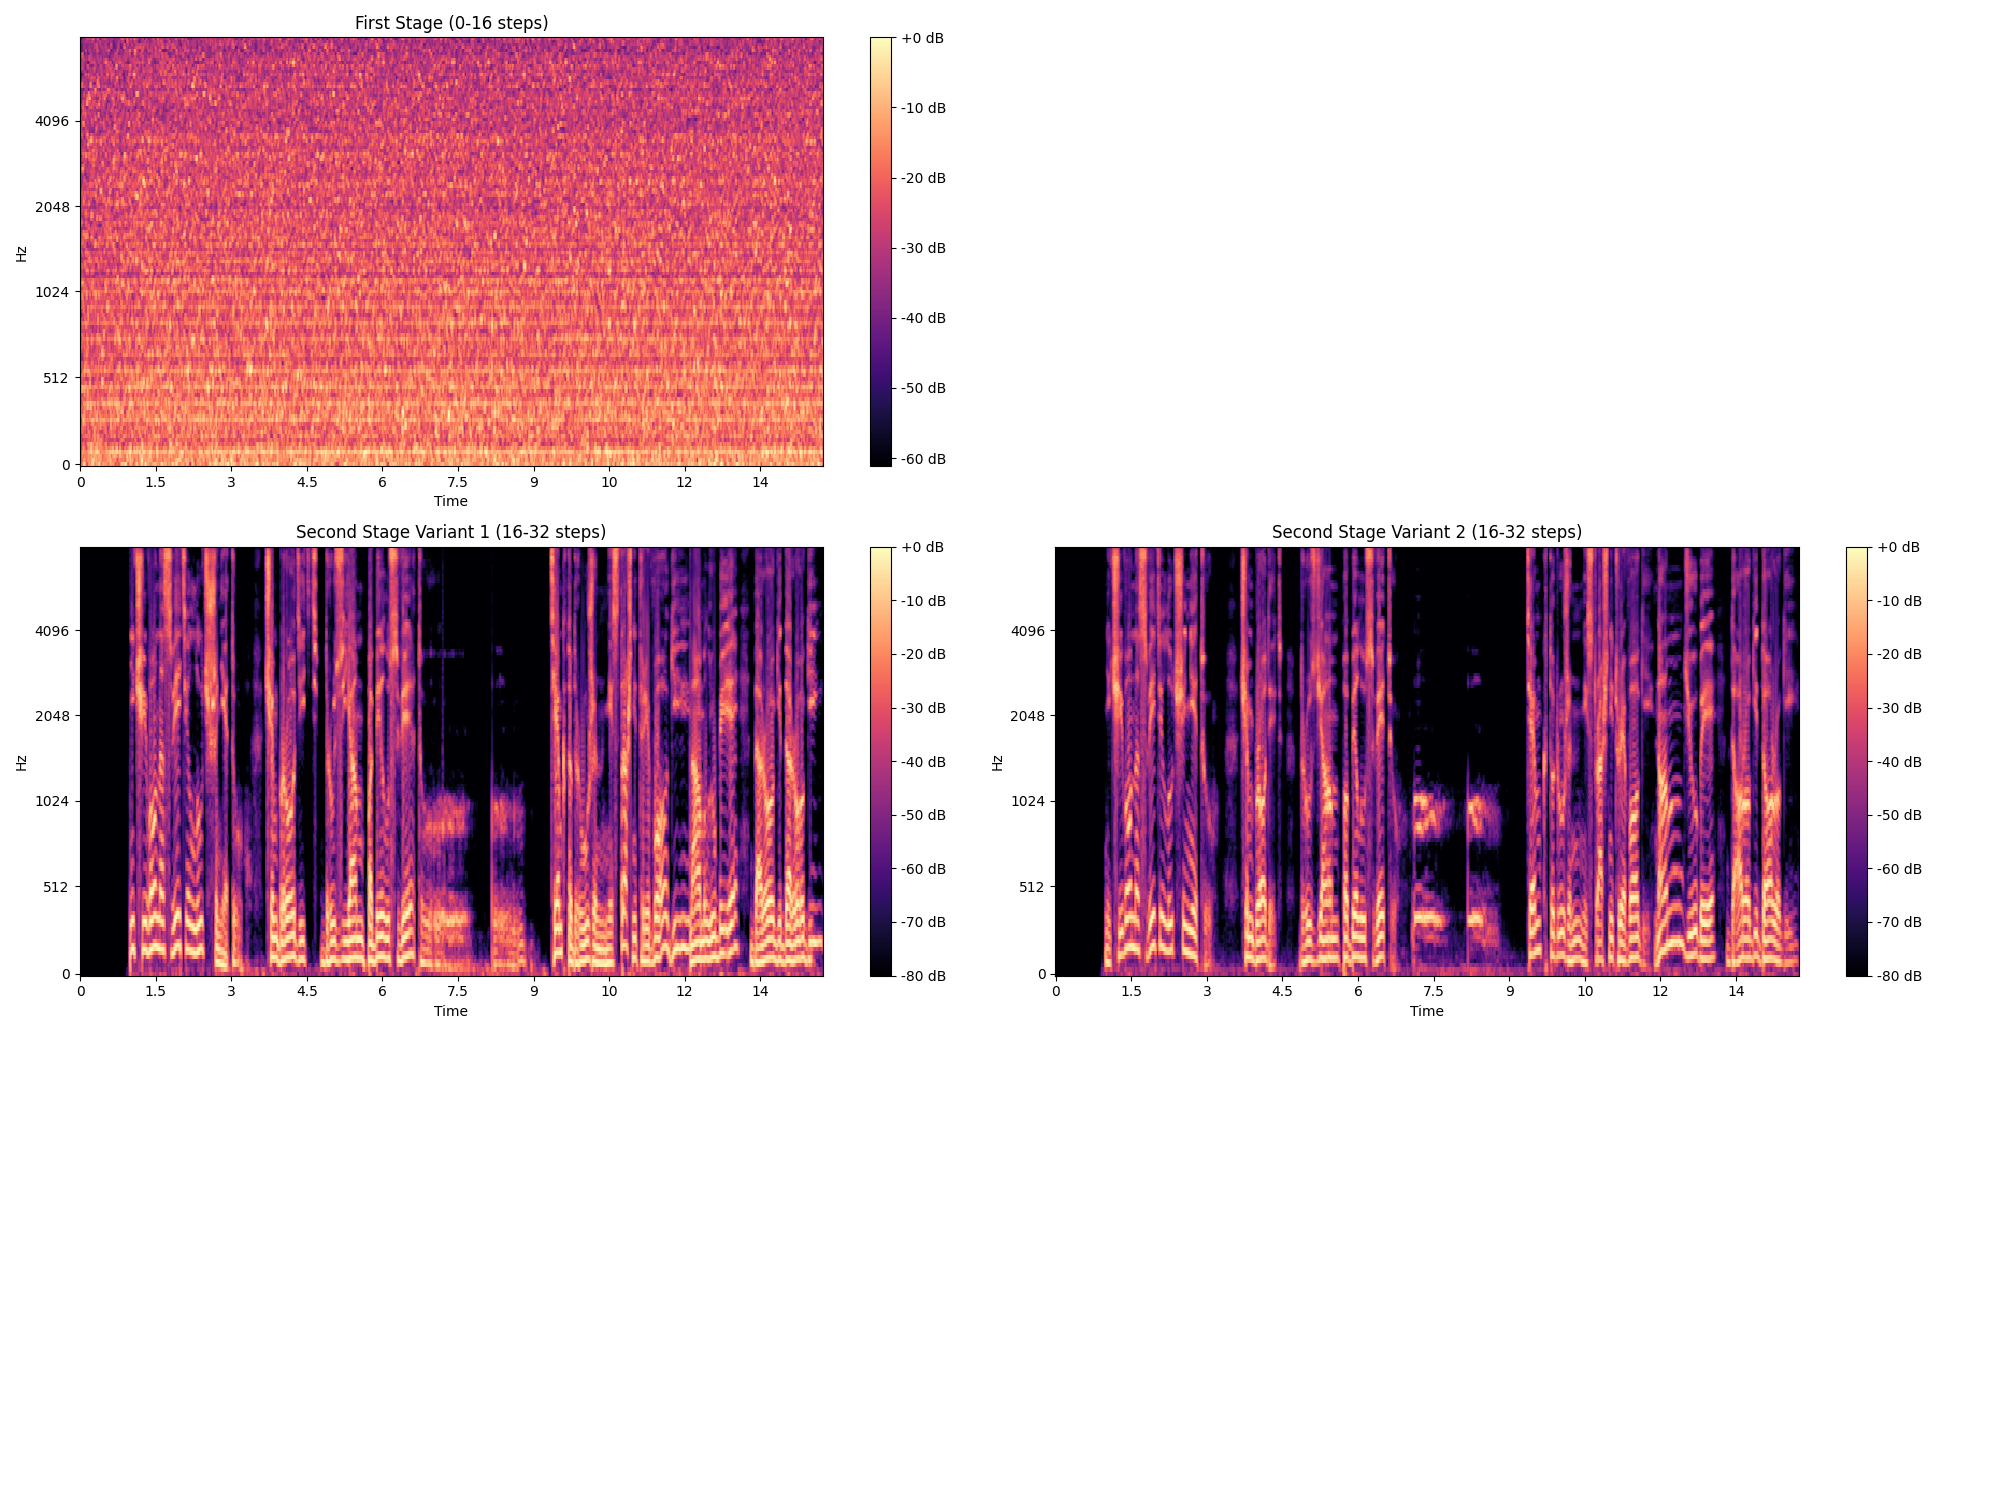

First stage audio (0-16 steps):



Second stage variants (16-32 steps):

Variant 1:



Variant 2:


In [37]:
# Cell 4 - Split generation experiment
import numpy as np
from IPython.display import display, Image, Audio
import matplotlib.pyplot as plt
import librosa
import librosa.display
import soundfile as sf

# Parameters for experiment
split_step = 3 # Split at step 16
steps = 32 # Steps for generation
speed = 0.9
variants = 2  # Number of different second-half generations

# Preprocess reference audio/text once
main_voice = {"ref_audio": ref_audio, "ref_text": ref_text}
ref_audio_preprocessed, ref_text_preprocessed = preprocess_ref_audio_text(main_voice["ref_audio"], main_voice["ref_text"])

# First stage - generate first 16 steps
first_audio, sr, _, first_trajectory = infer_single_process(
    ref_audio_preprocessed, ref_text_preprocessed, gen_text, ema_model, vocoder, 
    mel_spec_type=mel_spec_type, 
    nfe_step=steps,  # Keep total steps same
    speed=speed,
    start_step=0,
    end_step=split_step,
    cfg_strength=2.0,
    seed=42  # Use a fixed seed for first stage
)

# Save first stage audio
first_wave_path = Path(output_dir) / "first_stage.wav"
sf.write(first_wave_path, first_audio, sr)

#'''
# Create figure for all spectrograms
plt.figure(figsize=(20, 15))

# First stage spectrogram
plt.subplot(3, 2, 1)
y, _ = librosa.load(first_wave_path, sr=None)
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128, fmax=8000)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
librosa.display.specshow(mel_spec_db, sr=sr, x_axis="time", y_axis="mel", fmax=8000, cmap="magma")
plt.colorbar(format="%+2.0f dB")
plt.title("First Stage (0-16 steps)")
#'''

# Generate 4 different continuations
second_wave_paths = []
second_trajectories = []

for i in range(variants):
    # Generate second half with different seed
    if i == 0:
        model = ema_model
    else:
        model = ema_model2

    second_audio, sr, _, trajectory = infer_single_process(
        ref_audio_preprocessed, ref_text_preprocessed, gen_text, model, vocoder,
        mel_spec_type=mel_spec_type,
        nfe_step=steps,  # Keep total steps same
        speed=speed,
        start_step=split_step,
        end_step=steps,
        initial_state=first_trajectory[-1],
        cfg_strength=4.0,
        seed=i + 100  # Different seed for each variant
    )
    
    # Save audio
    wave_path = Path(output_dir) / f"second_stage_variant_{i}.wav"
    sf.write(wave_path, second_audio, sr)
    second_wave_paths.append(wave_path)
    second_trajectories.append(trajectory)
    
    #'''
    # Plot spectrogram (using positions 3,4,5,6 in a 3x2 grid)
    plt.subplot(3, 2, i + 3)
    y, _ = librosa.load(wave_path, sr=None)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128, fmax=8000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    librosa.display.specshow(mel_spec_db, sr=sr, x_axis="time", y_axis="mel", fmax=8000, cmap="magma")
    plt.colorbar(format="%+2.0f dB")
    plt.title(f"Second Stage Variant {i+1} (16-32 steps)")
    #'''

#'''    
# Save the combined plot
combined_spec_path = Path(output_dir) / "combined_spectrograms.png"
plt.tight_layout()
plt.savefig(combined_spec_path)
plt.close()

# Display the combined spectrograms
display(Image(filename=combined_spec_path))

# Display all audio samples
print("First stage audio (0-16 steps):")
#'''

display(Audio(first_wave_path))

print("\nSecond stage variants (16-32 steps):")
for i, path in enumerate(second_wave_paths):
    print(f"\nVariant {i+1}:")
    display(Audio(path))